In [1]:
import requests
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
import time
import seaborn as sn
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from itertools import groupby
import itertools
import statistics
import yfinance as yf

In [2]:
import websocket, json
import numpy as np
import pandas as pd
from binance.enums import *
import requests
from datetime import datetime
import config
from binance.client import Client
import time

# DESCARGA DE DATOS
symbol = 'ETHUSDT'
tick_interval = '5m'

def get_candles(start='', symbol=symbol, tick_interval=tick_interval, limit=1000):
    base_url = 'https://api.binance.com/'
    endpoint = 'api/v3/klines?'

    if start:
        query = 'symbol=' + symbol + '&interval=' + tick_interval + '&startTime=' + str(start) + '&limit=' + str(limit)
    else:
        query = 'symbol=' + symbol + '&interval=' + tick_interval + '&limit=' + str(limit)

    candles = requests.get(base_url + endpoint + query).json()

    return candles, candles[-1][6]


def get_all_candles_from_start(symbol, tick_interval):  # devuelve una lista de velas, cada vela es una lista tb
    start = 1502942400000  # 17 de agosto de 2017
    _, last_time = get_candles(start='', symbol=symbol, tick_interval=tick_interval, limit=1)
    candles = []
    while start < last_time:
        i_candles, next_hop = get_candles(start, symbol, tick_interval)
        candles = candles + i_candles
        start = next_hop
    return candles

In [3]:
# DATAFRAME DATOS
candles = get_all_candles_from_start(symbol, tick_interval)
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote', 'trades', 'takers_buy_base',
           'takers_buy_quote', 'ignore']
df = pd.DataFrame(candles, columns=columns)
df = df.sort_values('close_time')
df.drop_duplicates(keep='last')
df = df.astype(float)
closes = df['close'].tolist()

In [8]:
df = df[['open', 'high', 'low', 'close']]

In [9]:
df['MA9'] = df['close'].rolling(window=9).mean()
df['MA18'] = df['close'].rolling(window=18).mean()
df['MA50'] = df['close'].rolling(window=50).mean()
df['MA200'] = df['close'].rolling(window=200).mean()

In [10]:
signal = np.where(df.high.shift(-8) > df.open * 1.015, 1, 0)

In [11]:
def transform(data,back,ret):
    no_index = data.reset_index()
    new_data = pd.DataFrame()
    for i in data:
        x = np.log(no_index[i]/no_index[i].shift(back))
        new_data[i] = x
    for j in ret:
        y = np.log(no_index['close']/no_index['close'].shift(j))
        new_data[f'ret_{str(j)}'] = y
    new_data.index = data.index
    new_data = new_data.iloc[200 + back:]
    return new_data

In [12]:
ret = [2,5,7,10,15]
df = transform(df, 1, ret)

In [18]:
signal = signal[-len(df):]

In [19]:
df['signal'] = signal

In [20]:
now = df[:300000]
later = df[300000:]

In [21]:
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
import tensorflow as tf
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

In [24]:
X = now.iloc[:,0:13].values
y = now.iloc[:,13].values
X = X.reshape(X.shape[0], X.shape[1], 1)

In [25]:
print(X.shape)
print(y.shape)

(300000, 13, 1)
(300000,)


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [29]:
def create_model(neurons_1, neurons_2, dropout):
    model = Sequential()
    model.add(Conv1D(neurons_1, 3,input_shape=(X_train.shape[1], X_train.shape[2]), padding = 'same', activation = 'relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(dropout))
    model.add(Conv1D(neurons_2, 3, activation = 'relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [ ]:
best_params = []
# create model
model = KerasClassifier(build_fn=create_model, batch_size=128, epochs=50,verbose=0)
# define the grid search parameters
neurons_1 = [32, 64, 128]
neurons_2 = [96, 128, 256]
dropout = [0.1, 0.3, 0.5]
param_grid = dict(neurons_1 = neurons_1, neurons_2 = neurons_2, dropout = dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=4, scoring=ftwo_scorer)
grid_result = grid.fit(X_train, y_train)
# summarize results
best_params=grid_result.best_params_
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [30]:
best_params = {'neurons_1': 32, 'neurons_2': 256, 'dropout': 0.5}

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [31]:
model = create_model(best_params['neurons_1'], best_params['neurons_2'], best_params['dropout'])
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 1000, batch_size = 128)

Epoch 1/1000
1149/1149 [==============================] - 6s 5ms/step - loss: 0.2140 - accuracy: 0.9394 - val_loss: 0.1944 - val_accuracy: 0.9407
Epoch 2/1000
1149/1149 [==============================] - 6s 5ms/step - loss: 0.1992 - accuracy: 0.9403 - val_loss: 0.1897 - val_accuracy: 0.9414
Epoch 3/1000
1149/1149 [==============================] - 5s 5ms/step - loss: 0.1965 - accuracy: 0.9404 - val_loss: 0.1866 - val_accuracy: 0.9416
Epoch 4/1000
1149/1149 [==============================] - 5s 5ms/step - loss: 0.1953 - accuracy: 0.9404 - val_loss: 0.1873 - val_accuracy: 0.9410
Epoch 5/1000
1149/1149 [==============================] - 5s 5ms/step - loss: 0.1941 - accuracy: 0.9407 - val_loss: 0.1950 - val_accuracy: 0.9414
Epoch 6/1000
1149/1149 [==============================] - 5s 5ms/step - loss: 0.1937 - accuracy: 0.9408 - val_loss: 0.1886 - val_accuracy: 0.9414
Epoch 7/1000
1149/1149 [==============================] - 5s 5ms/step - loss: 0.1939 - accuracy: 0.9406 - val_loss: 0.1864 -

In [32]:
val_loss = history.history['val_loss']
loss = history.history['loss']

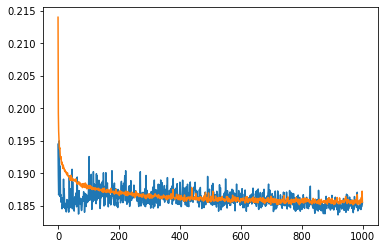

In [33]:
plt.plot(val_loss)
plt.plot(loss)

In [47]:
X = later.iloc[:,0:13].values
y = later.iloc[:,13].values
X = X.reshape(X.shape[0], X.shape[1], 1)

In [48]:
pred = model.predict(X)

In [55]:
count = 0
for i in pred:
    if i > 0.5:
        count += 1
print(count)
print(len(pred))

80
69311


In [56]:
# DATAFRAME DATOS
candles = get_all_candles_from_start(symbol, tick_interval)
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote', 'trades', 'takers_buy_base',
           'takers_buy_quote', 'ignore']
df = pd.DataFrame(candles, columns=columns)
df = df.sort_values('close_time')
df.drop_duplicates(keep='last')
df = df.astype(float)
closes = df['close'].tolist()

In [57]:
df = df[['open', 'high', 'low', 'close']]

In [59]:
df = df[-69311:]

In [134]:
sequence = []
for i in pred:
    if i > 0.35:
        sequence.append(1)
    else:
        sequence.append(0)

In [135]:
df['signal'] = sequence

In [136]:
buy = np.where(df.signal == 1)[0]

In [138]:
bs = []
for i in buy:
    if 54000 < i < 58000 :
        bs.append(i - 54000)

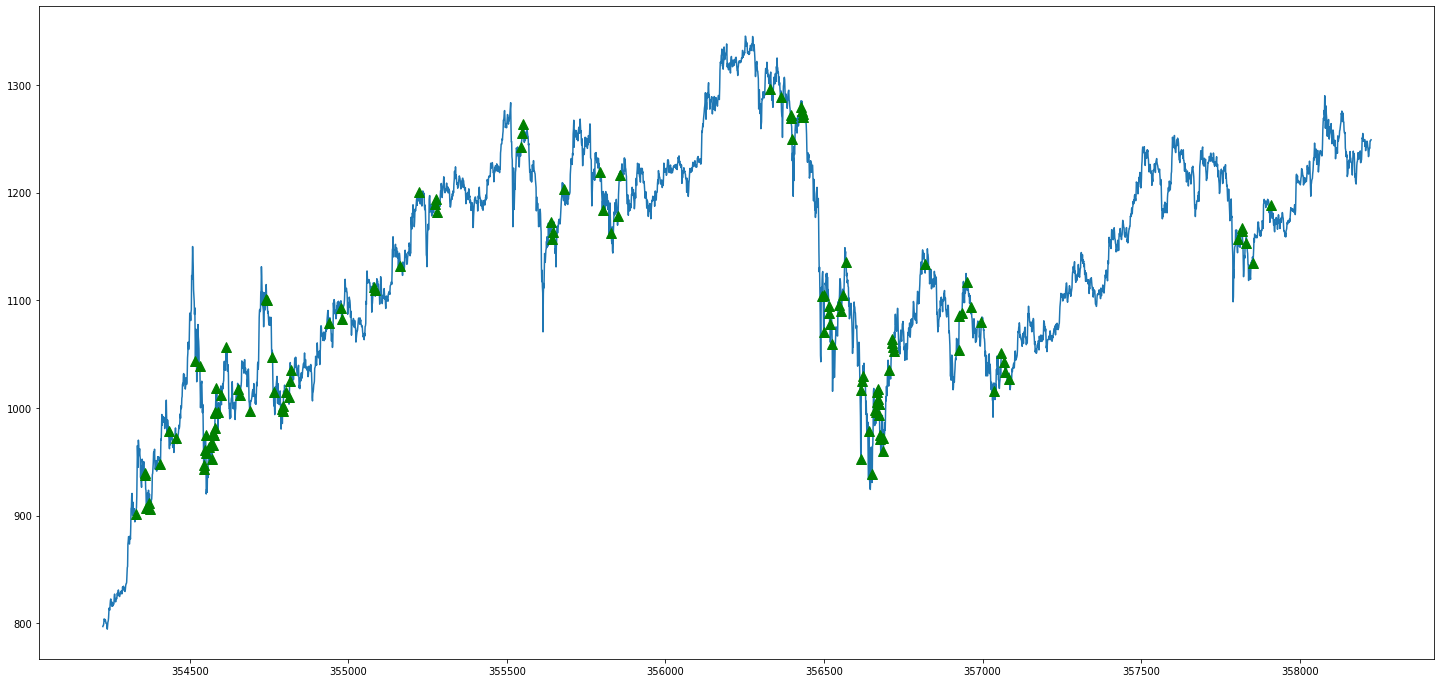

In [139]:
plt.figure(figsize = (25,12))
plt.plot(df.close[54000:58000])
plt.plot(df.close[54000:58000], '^', markevery=bs, markersize=10, color='g')

In [140]:
loss = 0.99
objective = 1.02
price = []
bought = False
bouhgt_at = 0
sold_at = 0
profit = []
bought_when = []
sold_when = []

for row in df.iterrows():
    label = row[1].signal
    close = row[1].close
    date = row[0]
    low = row[1].low
    if bought == False:
        if label == 0:
            price.append(0)
        elif label == 1: 
            bought = True
            price.append(close * loss)
            bought_at = close
            bought_when.append(date) 
    elif bought == True:
        if (close * loss) >= price[-1]:
            if close > bought_at * objective:
                bought = False
                sold_at = bought_at * objective
                price.append(0)
                profit.append(sold_at/bought_at)
                sold_when.append(date)
            else:
                price.append(close * loss)
        elif ((close * loss) < price[-1]) & (close > price[-1]):
            price.append(price[-1])
        elif low < price[-1]:
            bought = False
            sold_at = price[-1]
            price.append(0)
            profit.append(sold_at/bought_at)
            sold_when.append(date)

In [141]:
count = 0
for i in profit:
    if i > 1:
        count += 1
count/len(profit)

0.43859649122807015

In [142]:
capital = 10000
for i in profit:
    capital *= i
    
print(capital)

14491.522023280377


In [143]:
capital = 10000

In [ ]:
BH = []
for row in df.iterrows():
    close = row[1]['close']
    c = close/df['close']
    z = capital * c
    BH.append(z)

In [ ]:
BH

In [38]:
curve = []
count = 0
for i in range(0, len(analysis - 1)):
    if (sold_when[count] == df.index[i]) & (count < len(profit) - 1):
        curve.append(profit[count])
        count += 1
    else:
        curve.append(1)

EC = []
for c in curve:
    capital *= c
    EC.append(capital)

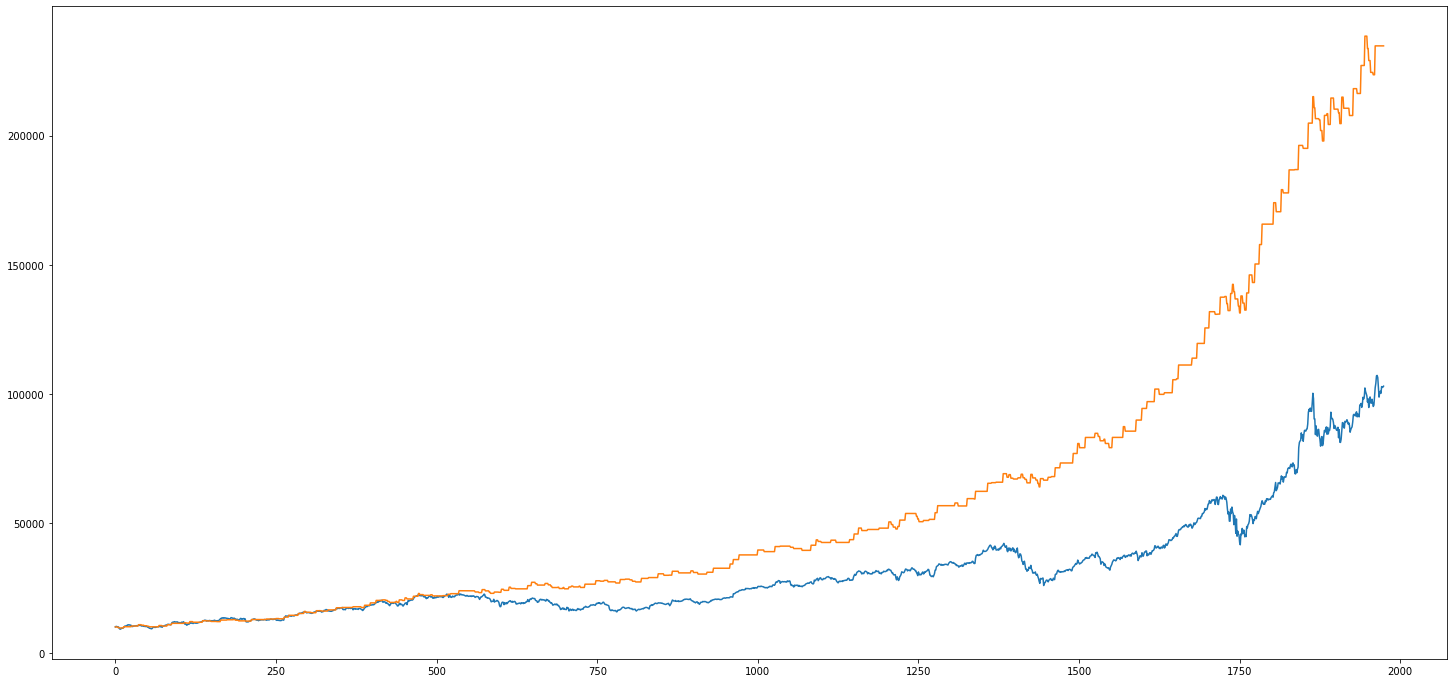

In [39]:
plt.figure(figsize = (25,12))
plt.plot(BH)
plt.plot(EC)